# Hypothesis

Given a users past shopping activity, we can accurately predict future purchases.

Initially, the model is based on:

* part of day (morning, eventing, afternoon, night)
* day (mon, tues...)
* amount spent
* market (Eua Claire, or Pittsville)
* Type of store (drug or supermarket)
* UPC (target, what product the user purchases)

Moving foward we can introduce demographic information into our model to improve accuracy.

In [200]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing, cross_validation
from pandas.tools.plotting import scatter_matrix
from sklearn import grid_search
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from itertools import combinations
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from collections import Counter

%pylab inline
pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [214]:
dr_sampling_rate=0.3
gr_sampling_rate=0.05

In [37]:
# local
saltsnck_dr_8=pd.read_fwf('saltsnck_drug_1479_1530').sample(frac=dr_sampling_rate)
saltsnck_dr_9=pd.read_fwf('saltsnck_drug_1531_1582').sample(frac=dr_sampling_rate)
saltsnck_dr_10=pd.read_fwf('saltsnck_drug_1583_1634').sample(frac=dr_sampling_rate)
saltsnck_dr_11=pd.read_fwf('saltsnck_drug_1635_1686').sample(frac=dr_sampling_rate)
saltsnck_dr_8_11=pd.concat([saltsnck_dr_8,saltsnck_dr_9,saltsnck_dr_10,saltsnck_dr_11]).reset_index(drop=True)
saltsnck_dr_8_11['OUTLET']='dr'

In [ ]:
# local
sugarsub_dr_8=pd.read_fwf('sugarsub_drug_1479_1530').sample(frac=dr_sampling_rate)
sugarsub_dr_9=pd.read_fwf('sugarsub_drug_1531_1582').sample(frac=dr_sampling_rate)
sugarsub_dr_10=pd.read_fwf('sugarsub_drug_1583_1634').sample(frac=dr_sampling_rate)
sugarsub_dr_11=pd.read_fwf('sugarsub_drug_1635_1686').sample(frac=dr_sampling_rate)
sugarsub_dr_8_11=pd.concat([sugarsub_dr_8,sugarsub_dr_9,sugarsub_dr_10,sugarsub_dr_11]).reset_index(drop=True)
sugarsub_dr_8_11['OUTLET']='dr'

In [215]:
saltsnck_gr_8=pd.read_fwf('saltsnck_groc_1479_1530').sample(frac=gr_sampling_rate)
saltsnck_gr_9=pd.read_fwf('saltsnck_groc_1531_1582').sample(frac=gr_sampling_rate)
saltsnck_gr_10=pd.read_fwf('saltsnck_groc_1583_1634').sample(frac=gr_sampling_rate)
saltsnck_gr_11=pd.read_fwf('saltsnck_groc_1635_1686').sample(frac=gr_sampling_rate)
saltsnck_gr_8_11=pd.concat([saltsnck_gr_8,saltsnck_gr_9,saltsnck_gr_10,saltsnck_gr_11]).reset_index(drop=True)
saltsnck_gr_8_11['OUTLET']='gr'

In [216]:
saltsnck_8_11=pd.concat([saltsnck_dr_8_11,saltsnck_gr_8_11])
saltsnck_8_11.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,OUTLET
0,1131996,1489,0,1,28400,6450,13,12.87,NONE,1,1,dr
1,8042848,1496,0,1,37000,37705,2,2.98,NONE,2,1,dr
2,8041943,1527,0,1,28400,6461,6,17.94,B,2,1,dr
3,8029617,1498,0,2,74690,5539,2,4.98,NONE,0,0,dr
4,8004916,1502,0,1,28400,6497,5,4.95,NONE,0,0,dr


In [217]:
saltsnck_8_11.shape

(6020309, 12)

In [218]:
# explicit mapping of F feature to reflect the ad size/importance
saltsnck_8_11.ix[saltsnck_8_11.F=='NONE', 'F'] = 1
saltsnck_8_11.ix[saltsnck_8_11.F=='C', 'F'] = 2
saltsnck_8_11.ix[saltsnck_8_11.F=='B', 'F'] = 3
saltsnck_8_11.ix[saltsnck_8_11.F=='A', 'F'] = 4
saltsnck_8_11.ix[saltsnck_8_11.F=='A+', 'F'] = 5

In [219]:
prod = pd.read_excel('prod11_saltsnck.xlsx')[['SY','GE','VEND','ITEM','L2']]
prod.head(1)

,SY,GE,VEND,ITEM,L2
0,0,1,72556,50003,POTATO CHIPS


In [220]:
saltsnck_prod_8_11 = pd.merge(saltsnck_8_11, prod, on=['SY', 'GE','VEND','ITEM'])
saltsnck_prod_8_11.drop(['SY', 'GE','VEND','ITEM'],axis=1, inplace=True)
saltsnck_prod_8_11.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2
0,1131996,1489,13,12.87,1,1,1,dr,TORTILLA/TOSTADA CHIPS
1,8026464,1519,6,5.94,1,1,0,dr,TORTILLA/TOSTADA CHIPS
2,643033,1517,1,0.86,1,0,1,dr,TORTILLA/TOSTADA CHIPS
3,1108960,1483,7,6.93,1,0,0,dr,TORTILLA/TOSTADA CHIPS
4,8013058,1494,1,0.99,1,0,0,dr,TORTILLA/TOSTADA CHIPS


In [221]:
from datetime import date, datetime
week_season_translation=pd.read_excel('IRI week translation_2008_2017.xls')
week_season_translation = week_season_translation[\
    ['IRI Week', u'Calendar week starting on',u'Calendar week ending on']]

# if the date falls between March 21 and June 20, it is spring. Regardless of the year. 
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
    
def get_season(rawDate):
    aDate = rawDate
    #datetime.strptime(rawDate, '%Y-%m-%d')
    if isinstance(aDate, datetime):
        aDate = aDate.date()
    aDate = aDate.replace(year=Y)
    
    return next(season for season, (start, end) in seasons
                if start <= aDate <= end)

week_season_translation['season'] = week_season_translation['Calendar week starting on']
week_season_translation['season'] = week_season_translation['season'].apply(get_season)
print "week_season_translation.shape =", week_season_translation.shape
week_season_translation.rename(columns={'IRI Week':'WEEK'}, inplace=True)
week_season_translation['YEAR']=week_season_translation['Calendar week starting on'].apply(lambda x:x.year)
week_season_translation['MONTH']=week_season_translation['Calendar week starting on'].apply(lambda x:x.month)
week_season_translation.drop(['Calendar week starting on','Calendar week ending on'], axis=1, inplace=True)
week_season_translation.head()

week_season_translation.shape = (522, 4)


,WEEK,season,YEAR,MONTH
0,1479,winter,2007,12
1,1480,winter,2008,1
2,1481,winter,2008,1
3,1482,winter,2008,1
4,1483,winter,2008,1


In [222]:
saltsnck_final=pd.merge(saltsnck_prod_8_11,week_season_translation,on='WEEK')
saltsnck_final.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2,season,YEAR,MONTH
0,1131996,1489,13,12.87,1,1,1,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
1,8026909,1489,5,4.95,1,1,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
2,8004374,1489,7,6.93,1,0,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
3,681547,1489,4,3.96,1,0,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
4,932621,1489,2,1.98,1,2,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3


# Data Cleaning

## Handling NaNs

In [223]:
# looking at the number of NaNs for each column #
saltsnck_final.isnull().sum()

IRI_KEY    0
WEEK       0
UNITS      0
DOLLARS    0
F          0
D          0
PR         0
OUTLET     0
L2         0
season     0
YEAR       0
MONTH      0
dtype: int64

In [224]:
def data_prep (data):
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=data.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    print "Non-numeric features are: ", non_num_feature
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #fill the NaN in non-numeric columns with the most used element#
        data.ix[:,col]=data.ix[:,col].fillna(data[col].describe().top)
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        data.ix[:,col]=le.fit_transform(data.ix[:,col])
    #Filling in NaN values of numeric features with the mean value of the feature
    data=data.fillna(data.mean())
    return data

In [225]:
saltsnck_preped=data_prep(saltsnck_final)
saltsnck_preped.head()

Non-numeric features are:  Index([u'OUTLET', u'L2', u'season'], dtype='object')


,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2,season,YEAR,MONTH
0,1131996,1489,13,12.87,1,1,1,0,7,3,2008,3
1,8026909,1489,5,4.95,1,1,0,0,7,3,2008,3
2,8004374,1489,7,6.93,1,0,0,0,7,3,2008,3
3,681547,1489,4,3.96,1,0,0,0,7,3,2008,3
4,932621,1489,2,1.98,1,2,0,0,7,3,2008,3


In [469]:
saltsnck_preped_grp=saltsnck_preped.groupby(['IRI_KEY','YEAR']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                                                     'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                                    'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                                     .reset_index(level=1).reset_index(drop=True)
saltsnck_preped_grp=saltsnck_preped_grp.ix[saltsnck_preped_grp['OUTLET']==0]
saltsnck_preped_grp.head(5)

,YEAR,PR,D,F,DOLLARS,L2,OUTLET,UNITS
1304,2008,272,87,1422,5657.49,4,0,4017
1305,2009,297,249,1646,7526.94,4,0,4781
1306,2010,378,110,1818,7770.60,4,0,5319
1307,2011,402,198,1894,8529.51,4,0,5058
1418,2007,6,0,17,99.82,4,0,49


,PR,D,F,DOLLARS,L2,OUTLET,UNITS
count,9298.000000,9298.000000,9298.000000,9298.000000,9298.000000,9298.000000,9298.00000
mean,177.066036,182.275973,797.650678,13670.327219,3.985051,0.738008,6009.50968
std,132.364855,178.729730,555.309974,13317.857672,0.663993,0.439742,5772.99589
min,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,1.00000
25%,58.000000,55.000000,446.250000,2309.747500,4.000000,0.000000,1263.75000
50%,180.000000,148.000000,829.000000,10975.350000,4.000000,1.000000,4936.00000
75%,257.000000,245.000000,1105.000000,20399.220000,4.000000,1.000000,8688.00000
max,983.000000,1578.000000,3608.000000,105422.340000,7.000000,1.000000,54126.00000


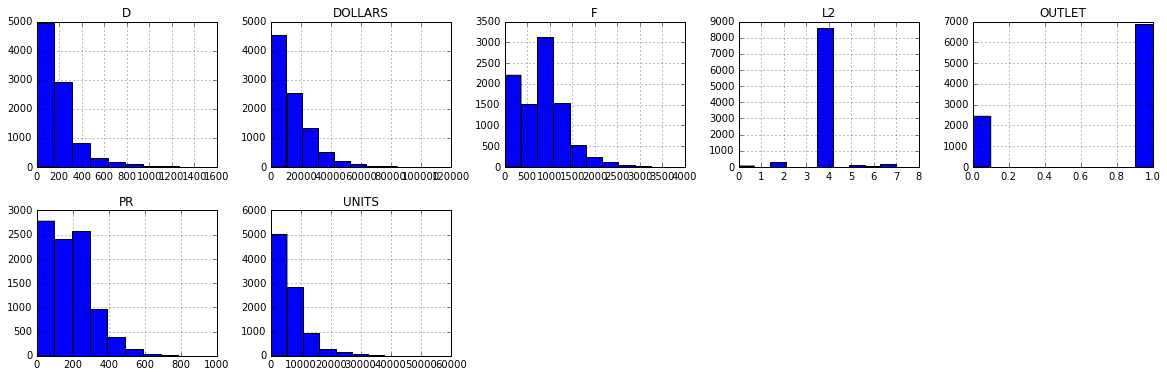

In [247]:
# looking at the histogram and statistics of the features to be able to omit features with not enough data #
saltsnck_preped_grp.hist(figsize=(20,50), layout=(15,5))
saltsnck_preped_grp.describe()

# Outlier Detection and Removal

**We assume that all features have Gaussian distribution and detect outliers based on the following rule:**

Detect a column with extreme outlier if $max (col)> mean(col)+10*\sigma $ 

In [132]:
def outlier_detector(data):
    out_col=[]
    data=data.copy()
    for col in data.describe().columns:
        maxx = data.describe()[col]['max']
        minn = data.describe()[col]['min']
        mean = data.describe()[col]['mean']
        std =  data.describe()[col]['std']

        if maxx>(mean+10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(data[col].ix[data[col]>(mean+10*std)].values)
            data=data[data[col]<(mean+10*std)]
        elif minn<(mean-10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(saltsnck_preped[col].ix[saltsnck_preped[col]>(mean-10*std)].values)
            data=data[data[col]>(mean-10*std)]
    print "columns containing outliers are: ",out_col
    return data

In [248]:
saltsnck_preped_grp=outlier_detector(saltsnck_preped_grp)

columns containing outliers are:  []


# Creating Model

# Natutral growth analysis

In [448]:
print "total sale in 2011:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['DOLLARS']].sum()
print "total sale in 2010:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2010][['DOLLARS']].sum()
print "total sale in 2009:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2009][['DOLLARS']].sum()
print "total sale in 2008:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2008][['DOLLARS']].sum()

total sale in 2011: DOLLARS    27536167.4
dtype: float64
total sale in 2010: DOLLARS    28470946.32
dtype: float64
total sale in 2009: DOLLARS    29581096.53
dtype: float64
total sale in 2008: DOLLARS    27676227.32
dtype: float64


In [450]:
print "total sale in 2010:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2010][['DOLLARS']].sum()/(saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "total sale in 2009:", saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2009][['DOLLARS']].sum()/(saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2008:", 1

total sale in 2010: DOLLARS    1.028715
dtype: float64
total sale in 2009: DOLLARS    1.068827
dtype: float64
growth factor for 2008: 1


# classifying the product category

### Decision Tree

In [470]:
X_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET']]
y_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['L2']]
X_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['PR','D','F','OUTLET']]
y_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['L2']]
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print "score on train set:", dtree.score(X_train, y_train)
print "score on test set:", dtree.score(X_test, y_test)

score on train set: 0.988849467816
score on test set: 0.952483801296


In [471]:
pca = decomposition.PCA()
pca.fit(X_train)
features = pca.transform(X_train)
pca.explained_variance_ratio_

array([ 0.95458455,  0.03953852,  0.00587693,  0.        ])

# predicting the dollar amount

### Random Forest

In [478]:
X_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET']]
y_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['PR','D','F','OUTLET']]
y_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011]['DOLLARS']
tree = RandomForestRegressor(random_state=0)
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)

score on train set: 0.970510590796
score on test set: 0.806239028433


# Stacking

In [283]:
## writing a class with fit/predict/scoring method, to fit the sub-classifiers onto the data and fit
# a meta classifier on top of the base classifier and evaluate the performance
class stacked_classifier():
    def __init__(self, base_classifiers=None, meta_classifier=None):
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier


    def fit(self, X, y):
        for classifier in self.base_classifiers:
            classifier.fit(X, y)
        X_meta=self.predict_base(X)
        self.meta_classifier.fit(X_meta, y)

    def predict_base(self, X):
        self.predictions = np.zeros(len(X))
        for classifier in self.base_classifiers:
            self.predictions=np.column_stack([self.predictions, classifier.predict(X)])
        return self.predictions
        
    def scoring(self,X,y):
        clf_score=[]
        for classifier in self.base_classifiers:
            clf_score.append(classifier.score(X, y))
        clf_score.append(self.meta_classifier.score(self.predict_base(X),y))
        return clf_score

# Creating sub and meta classifiers

In [242]:
DTC = DecisionTreeClassifier(random_state=0)
LR = linear_model.LogisticRegression()
RC =  linear_model.RidgeClassifier(random_state=1)
ETC = ExtraTreeClassifier(random_state=32)
KNC = KNeighborsClassifier ()
BC = BaggingClassifier()

In [406]:
DTR = DecisionTreeRegressor(random_state=0)
RR =  linear_model.Ridge(random_state=1)
BRR= linear_model.BayesianRidge()
ETR = ExtraTreeRegressor(random_state=32)
LR = linear_model.Lasso()
RFR = RandomForestRegressor()
SGDR = linear_model.SGDRegressor()

# Importing the results of all possible combinations of base+meta classifier into a DataFrame

In [386]:
def stack_scoring(clf_dict, score_df, n, X_train, X_test, y_train, y_test):
    l=0
    for clf in combinations(clf_dict,n):
        stacked_clf=stacked_classifier(base_classifiers=clf[0:n-1], meta_classifier=clf[n-1])
        stacked_clf.fit(X_train,y_train)
        clf_scores=[clf_dict.get(clf[i]) for i in range(n)]+stacked_clf.scoring(X_test,y_test)
        score_df.loc[l]= clf_scores
        l+=1
    return score_df

In [481]:
X_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET']]
y_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011]['L2']
X_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['PR','D','F','OUTLET']]
y_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011]['L2']
clf_dict={DTC: 'Decision Tree',LR:'Logistic Regression',RC: 'Ridge', ETC: 'Extra Tree', KNC:'KNeighbor', BC:'Bagging'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1                   Extra Tree
Base2          Logistic Regression
Base3                Decision Tree
Meta                         Ridge
Base1 Score               0.950324
Base2 Score             -0.0646769
Base3 Score               0.952484
Meta Score                0.976242
Name: 2, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Extra Tree,Logistic Regression,Decision Tree,Bagging,0.950324,-0.064677,0.952484,0.954644
1,Extra Tree,Logistic Regression,Decision Tree,KNeighbor,0.950324,-0.064677,0.952484,0.950324
2,Extra Tree,Logistic Regression,Decision Tree,Ridge,0.950324,-0.064677,0.952484,0.976242
3,Extra Tree,Logistic Regression,Bagging,KNeighbor,0.950324,-0.064677,0.963283,0.952484
4,Extra Tree,Logistic Regression,Bagging,Ridge,0.950324,-0.064677,0.963283,0.976242
5,Extra Tree,Logistic Regression,KNeighbor,Ridge,0.950324,-0.064677,0.969762,0.976242
6,Extra Tree,Decision Tree,Bagging,KNeighbor,0.950324,0.952484,0.961123,0.941685
7,Extra Tree,Decision Tree,Bagging,Ridge,0.950324,0.952484,0.963283,0.976242
8,Extra Tree,Decision Tree,KNeighbor,Ridge,0.950324,0.952484,0.969762,0.976242
9,Extra Tree,Bagging,KNeighbor,Ridge,0.950324,0.965443,0.969762,0.976242


In [480]:
X_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET']]
y_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['PR','D','F','OUTLET']]
y_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011]['DOLLARS']
clf_dict={DTR: 'Decision Tree',RR: 'Ridge', ETR: 'Extra Tree', BRR:'Bayesian Ridge', LR:'Lasso', RFR: 'Random Forrest'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1                   Lasso
Base2                   Ridge
Base3          Random Forrest
Meta           Bayesian Ridge
Base1 Score          0.713969
Base2 Score          0.713969
Base3 Score          0.788887
Meta Score           0.769248
Name: 10, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Decision Tree,Lasso,Ridge,Random Forrest,0.664750,0.713969,0.713969,0.668532
1,Decision Tree,Lasso,Ridge,Bayesian Ridge,0.664750,0.713969,0.713969,0.664750
2,Decision Tree,Lasso,Ridge,Extra Tree,0.664750,0.713969,0.713969,0.666145
3,Decision Tree,Lasso,Random Forrest,Bayesian Ridge,0.664750,0.713969,0.771368,0.664750
4,Decision Tree,Lasso,Random Forrest,Extra Tree,0.664750,0.713969,0.778586,0.682564
5,Decision Tree,Lasso,Bayesian Ridge,Extra Tree,0.664750,0.713969,0.714209,0.668791
6,Decision Tree,Ridge,Random Forrest,Bayesian Ridge,0.664750,0.713969,0.787088,0.664750
7,Decision Tree,Ridge,Random Forrest,Extra Tree,0.664750,0.713969,0.758898,0.667163
8,Decision Tree,Ridge,Bayesian Ridge,Extra Tree,0.664750,0.713969,0.714209,0.673360
9,Decision Tree,Random Forrest,Bayesian Ridge,Extra Tree,0.664750,0.792239,0.714209,0.682659


In [479]:
X_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET']]
y_train = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011][['PR','D','F','OUTLET']]
y_test = saltsnck_preped_grp.ix[saltsnck_preped_grp['YEAR']==2011]['DOLLARS']
clf_dict={DTR: 'Decision Tree',RR: 'Ridge', ETR: 'Extra Tree', BRR:'Bayesian Ridge', LR:'Lasso', RFR: 'Random Forrest'}
score_df = pd.DataFrame(columns=['Base1','Base2', 'Meta','Base1 Score','Base2 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 3, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1                   Lasso
Base2          Random Forrest
Meta           Bayesian Ridge
Base1 Score          0.713969
Base2 Score          0.806482
Meta Score           0.791809
Name: 13, dtype: object


,Base1,Base2,Meta,Base1 Score,Base2 Score,Meta Score
0,Decision Tree,Lasso,Ridge,0.664750,0.713969,0.664750
1,Decision Tree,Lasso,Random Forrest,0.664750,0.713969,0.663053
2,Decision Tree,Lasso,Bayesian Ridge,0.664750,0.713969,0.664750
3,Decision Tree,Lasso,Extra Tree,0.664750,0.713969,0.660549
4,Decision Tree,Ridge,Random Forrest,0.664750,0.713969,0.663589
5,Decision Tree,Ridge,Bayesian Ridge,0.664750,0.713969,0.664750
6,Decision Tree,Ridge,Extra Tree,0.664750,0.713969,0.660549
7,Decision Tree,Random Forrest,Bayesian Ridge,0.664750,0.758358,0.664750
8,Decision Tree,Random Forrest,Extra Tree,0.664750,0.788392,0.695081
9,Decision Tree,Bayesian Ridge,Extra Tree,0.664750,0.714209,0.660549
